# Wind Exploration of Mike Trout's homerun

This simulation will model a trajectory of Mike Trout's home run with no wind, tail wind, and head wind.

## Research Questions:

1. How much headwind would prevent a home run?
2. How much headwind is needed to lose 10% of distance
3. How much tailwind is needed to gain 10% of distance?

## Magnus Effect and Drag

The Magnus effect is the force exerted by the air on a spinning ball. Backspin lifts the ball, topspin dives the ball, and side spin twists the ball left or right. 

$$\vec{F}_{magnus} = \alpha \vec{\omega} \times \vec{v}_r$$

$\alpha$ is a constant with the dimensions of mass. Since the direction of the Magnus force is perpendicular to the velocity, the ball will always curve but will not change speed if no work is present.

The spin parameter is defined:
$r$ is the radius of the ball, $omega$ is the angular velocity, and $v$ is the speed

$$S = \frac{r\omega}{v}$$

The Magnus force is written:

$$\vec{F}_{magnus} = \frac{1}{2}C_L \frac{\rho A r}{S} \vec{\omega} \times \vec{v}$$

The lift coefficient $C_L$ is dependent on the spin factor.

$$C_L = 0.62S^{0.7}$$

The drag force $F_d$ is defined as:

$$\vec{F}_{d} = -bv_r\vec{v}_r$$


$\vec{vr}$ is defined as:

$$\vec{v}_{r} = \vec{v} -  \vec{v}_{wind}$$




## Computational Model

This simulation of baseball is below. Run each cell in sequence to continue to the next one. The wind, tailwind, and backspin distances will return with a value. A graph will appear looking at all three scenarios. 

## Assumptions

Assume that the angular velocities are constant for gravitation, drag, and Magnus force.

In [1]:
import ode #ode.py should be in the same folder as your notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#parameters
g = 9.8 #N/kg
rho = 1.2 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 74e-3/2 #74 mm diameter, 9.25" in circumference
A = np.pi*r**2 #cross-sectional area
Cd = 0.5 #actually depends on speed
m = 0.145 #kg
b2 = 1/2*Cd*rho*A #will change as Cd changes

S = 0.01 #will change as omega and v change
CL = 0 #will change with S
alpha = 1/2*CL*rho*A*r/S

# data for home run
vmag0mph = 111.1 #mph
thetadeg = 25 #deg
spinrate = 1838 #rpm

vwindx = 0
vwindy = 0
vwindz = 0

# convert units and create initial conditions
vmag0 = vmag0mph*0.44704 #convert mph to m/s
theta = thetadeg*np.pi/180 #convert deg to rad

# initial angular speed and velocity
omegamag = spinrate * 2*np.pi / 60 #convert to rad/s
omegax = 0
omegay = 0
omegaz = omegamag

In [3]:
def go(vwx,vwy,vwz):
    
    global vwindx,vwindy,vwindz
    vwindx = vwx
    vwindy = vwy
    vwindz = vwz
    
    t = 0 #time in s
    h = 1e-2 #time step in s

    # initial position and velocity components
    x = 0
    y = 0
    z = 0
    vrx = vmag0*np.cos(theta)
    vry = vmag0*np.sin(theta)
    vrz = 0

    # lists for storing data to graph
    Magtlist = []
    Magxlist = []
    Magylist = []
    Magzlist = []

    # store initial values
    Magtlist.append(t)
    Magxlist.append(x)
    Magylist.append(y)
    Magzlist.append(z)

    data = np.array([x,y,z,vrx,vry,vrz]) 

    # compute
    while y >= 0: #stop when ball hits the ground

        data = ode.RK4(magnus, data, t, h)
        t = t + h

        x = data[0]
        y = data[1]
        z = data[2]
        Magtlist.append(t)
        Magxlist.append(x)
        Magylist.append(y)
        Magzlist.append(z)
        
    traj = np.zeros((len(Magtlist),4))
    traj[:,0] = Magtlist
    traj[:,1] = Magxlist
    traj[:,2] = Magylist
    traj[:,3] = Magzlist
    
    
    return traj

In [4]:
def distance(traj):
    d = traj[-1,1]
    return d

def ploty(traj):
    # Plot the trajectory
    plt.figure(figsize = (8,6))
    plt.title("Trajectory")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.plot(traj[:,1], traj[:,2], 'r-')
    plt.show()

def magnus(d, t):
    
    x = d[0]
    y = d[1]
    z = d[2]
    vx = d[3]
    vy = d[4]
    vz = d[5]

    dxdt = vx
    dydt = vy
    dzdt = vz
    
    vrx = vx-vwindx
    vry = vy-vwindy
    vrz = vz-vwindz
    
    vr = np.sqrt(vrx**2 + vry**2 + vrz**2)
    vc = 34
    a = 0.36
    b = 0.14
    c = 0.27
    chi = (vr-vc)/4
 
    if chi < 0 :
        Cd = a+b/(1+np.exp(chi))-c * np.exp(-chi**2)
    else:
        Cd = a+b/(1+np.exp(chi))-c * np.exp(-chi**2/4)
    
    Fdragx = -1/2*Cd*rho*A*vr**2 * vrx/vr
    Fdragy = -1/2*Cd*rho*A*vr**2 * vry/vr
    Fdragz = -1/2*Cd*rho*A*vr**2 * vrz/vr
    

    S = (r*omegamag) / vr
    CL = (0.62 * (S**0.7))

    
    FMagnusx0 = (1/2) * CL * rho * ((A * r)/S) * (omegay * vrz - omegaz * vry)
    FMagnusy0 = (1/2) * CL * rho * ((A * r)/S) * (omegaz * vrx - omegax * vrz)
    FMagnusz0 = (1/2) * CL * rho * ((A * r)/S) * (omegax * vry - omegay * vrx)
    


    Fgravy = -m*g
    
    Fnetx = Fdragx + FMagnusx0
    Fnety = Fgravy + Fdragy + FMagnusy0
    Fnetz = Fdragz + FMagnusz0
    
    dvxdt = Fnetx/m
    dvydt = Fnety/m
    dvzdt = Fnetz/m
    
    
    derivs = np.array([dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt])
    
    return derivs

# Validation

### No Wind

In [5]:
traj_no_wind = go(0,0,0)

In [6]:
distance(traj_no_wind)

152.1215897175049

A backspin with no wind results in a distance of 152.12 meters (498.9 feet). 

### Headwind

In [8]:
traj_headwind = go(-11.1*.447,0,0)

In [9]:
distance(traj_headwind)

136.89036021399568

A baseball that has a headwind of 11.1 mph resulted in a shorter distance of 136.89 meters. A 10 percent distance compared to no wind resulted in a wind speed of -11.1 in the x direction

### Tailwind

In [11]:
traj_tailwind = go(14.2*0.447,0,0)

In [12]:
distance(traj_tailwind)

167.3496510678226

A baseball with a tailwind of 14.2 resulted in a larger distance of 167.3 meters. A 10 percent distance compared to no wind resulted in a wind speed of +14.2 in the x direction.

## Plot of all Three Scenario's

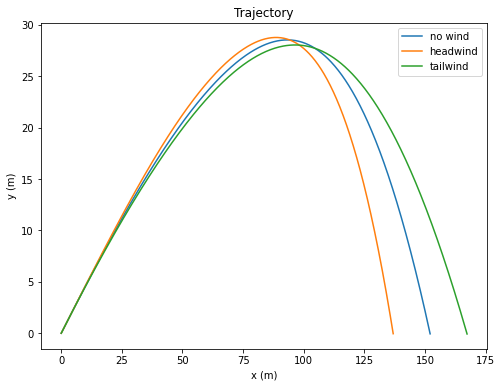

In [13]:
# Plot the trajectory
plt.figure(figsize = (8,6))
plt.title("Trajectory")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(traj_no_wind[:,1], traj_no_wind[:,2], label="no wind")
plt.plot(traj_headwind[:,1], traj_headwind[:,2], label="headwind")
plt.plot(traj_tailwind[:,1], traj_tailwind[:,2], label="tailwind")
plt.legend()
plt.show()

## Conclusion

We calculated and displayed a graph comparing the distance that the baseball travels when there is no wind, tailwind, and headwind. The baseball with no wind traveled 152.12 meters. When the baseball had a headwind, it traveled 136.89 meters. When the baseball had a tailwind, it traveled 167.35 meters. Overall, we expected the tailwind to travel further because the tailwind is pushing the ball forward. We confirmed this hypothesis by plotting and calculating how far the baseball would go.